In [2]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/Users/prudhvivuda/Documents/polygraphs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
processor.add_config("reliability")

In [4]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

blfs = beliefs.copy()

In [5]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [6]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499112,0.498167,0.289292,0.000005,0.999994,0.248027,0.750531
1,BalaGoyalOp,1,0.499647,0.49885,0.289438,0.000005,0.999994,0.248377,0.751215
2,BalaGoyalOp,100,0.554684,0.583315,0.305598,0.000002,0.999999,0.287227,0.835387
3,BalaGoyalOp,200,0.61072,0.675926,0.314457,0.000001,1.0,0.340673,0.904614
4,BalaGoyalOp,300,0.660106,0.762326,0.31689,0.0,1.0,0.402658,0.950697
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.908092,0.999999,0.256325,0.0,1.0,0.999843,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.90824,0.999999,0.256129,0.0,1.0,0.999845,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.90778,0.999999,0.256638,0.0,1.0,0.99984,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.908298,0.999999,0.256058,0.0,1.0,0.999854,1.0


## ANOVA Test

#### Hypotheses

- Null Hypothesis: \( H_0 \): There is no significant difference in mean credence across operators.
- Alternative Hypothesis: \( H_a \): There is a significant difference in mean credence across operators.

In [7]:
# Group data by 'op' and collect mean beliefs
grouped = aggregated_beliefs.groupby('op')['mean_beliefs'].apply(list).reset_index()

# Perform ANOVA test
anova_result = stats.f_oneway(*grouped['mean_beliefs'])
print(f"ANOVA Test: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA Test: F-statistic = 97.20475006103516, p-value = 0.0


Reject the null hypothesis.

## Tukey's HSD Test

Let's compare all pairs of groups to find where the differences lie.

                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                       
                   group1                                       group2                    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------
                                BalaGoyalOp      UnreliableNetworkBasicGullibleBinomialOp  -0.0239 0.0082 -0.0437  -0.004   True
                                BalaGoyalOp   UnreliableNetworkBasicGullibleNegativeEpsOp  -0.1081    0.0 -0.1279 -0.0882   True
                                BalaGoyalOp                      UnreliableNetworkIdealOp  -0.0162 0.1814 -0.0361  0.0036  False
                                BalaGoyalOp    UnreliableNetworkModifiedAlignedBinomialOp  -0.0259 0.0029 -0.0457  -0.006   True
                                BalaGoyalOp UnreliableNetworkModifiedAlignedNegativeEpsOp  -0.109

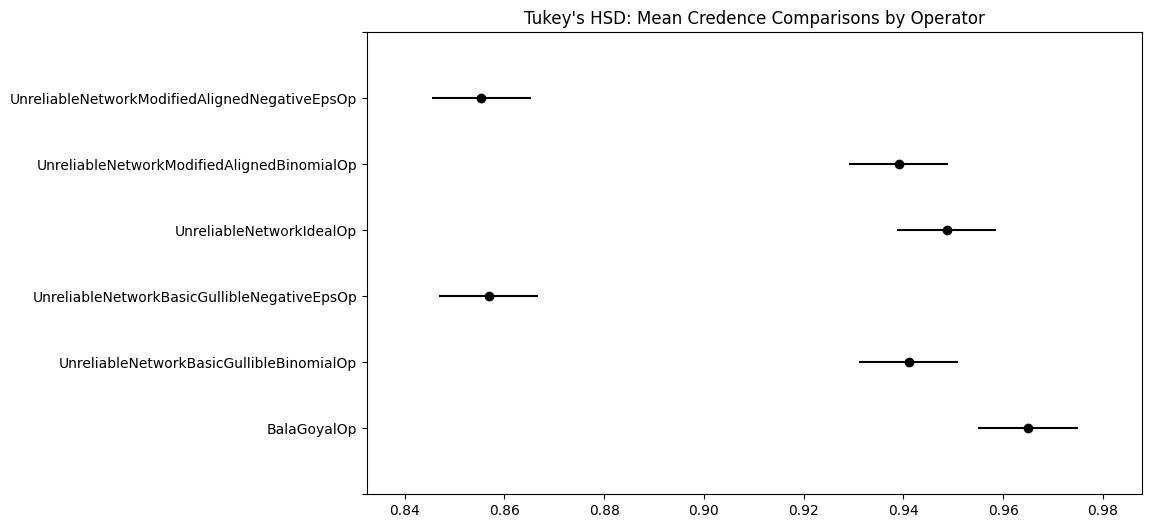

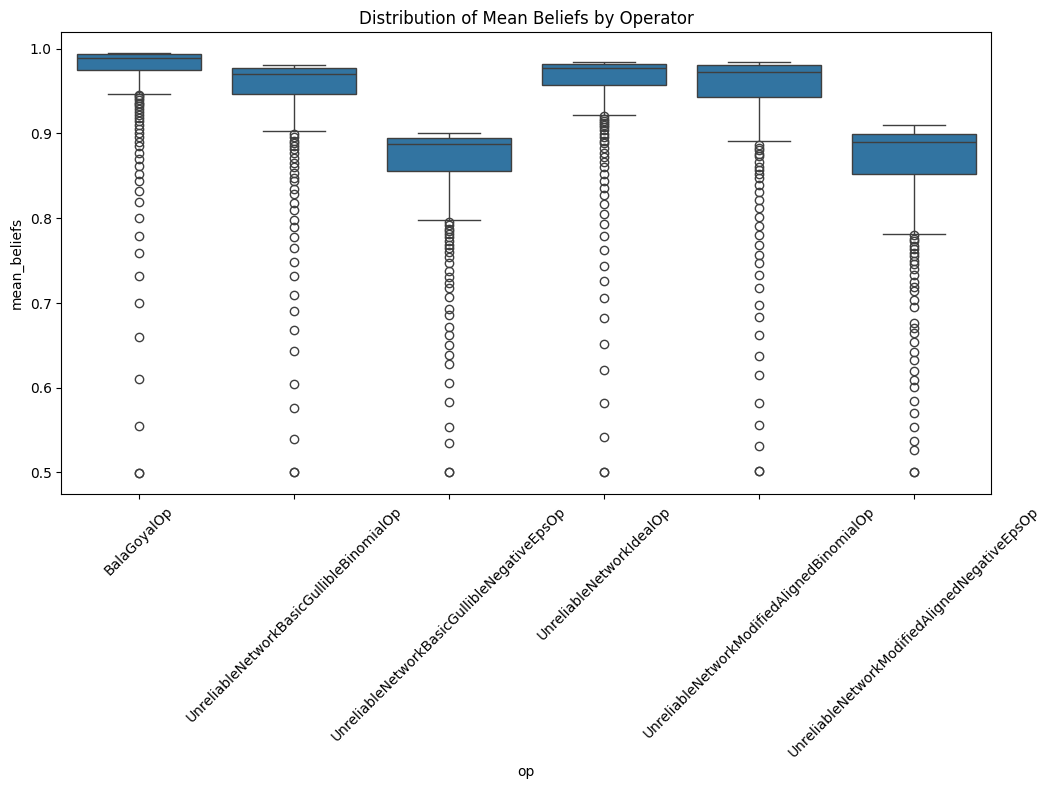

In [8]:
# Tukey's HSD Test
tukey_data = aggregated_beliefs[['op', 'mean_beliefs']].dropna()

tukey = pairwise_tukeyhsd(
    endog=tukey_data['mean_beliefs'],
    groups=tukey_data['op'],
    alpha=0.05
)

print(tukey)

# Visualize Pairwise Comparisons
fig = tukey.plot_simultaneous()
plt.title("Tukey's HSD: Mean Credence Comparisons by Operator")
plt.show()

# Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='op', y='mean_beliefs', data=aggregated_beliefs)
plt.title('Distribution of Mean Beliefs by Operator')
plt.xticks(rotation=45)
plt.show()


## Kolmogorov-Smirnov Test

Pairwise comparisons of distributions for each op.

In [9]:
# Pairwise KS Test
print("\nKolmogorov-Smirnov Test Results:")
for i, op1 in enumerate(grouped['op']):
    for j, op2 in enumerate(grouped['op']):
        if i < j:
            ks_stat, p_value = kstest(grouped.loc[i, 'mean_beliefs'], grouped.loc[j, 'mean_beliefs'])
            print(f"{op1} vs {op2}: KS-statistic = {ks_stat}, p-value = {p_value}")


Kolmogorov-Smirnov Test Results:
BalaGoyalOp vs UnreliableNetworkBasicGullibleBinomialOp: KS-statistic = 0.6825396825396826, p-value = 3.108153803200769e-56
BalaGoyalOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.9206349206349206, p-value = 3.3729780058779814e-115
BalaGoyalOp vs UnreliableNetworkIdealOp: KS-statistic = 0.6349206349206349, p-value = 5.159806972040643e-48
BalaGoyalOp vs UnreliableNetworkModifiedAlignedBinomialOp: KS-statistic = 0.626984126984127, p-value = 9.994514232321966e-47
BalaGoyalOp vs UnreliableNetworkModifiedAlignedNegativeEpsOp: KS-statistic = 0.9126984126984127, p-value = 1.7067268709742586e-112
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.873015873015873, p-value = 4.4917342878221054e-100
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkIdealOp: KS-statistic = 0.36507936507936506, p-value = 2.527075621186129e-15
UnreliableNetworkBasicGullibleBinomialOp vs Unreliable

## Average belief under each operation at steps 5k, 10k, 15k, 20k, and 25k

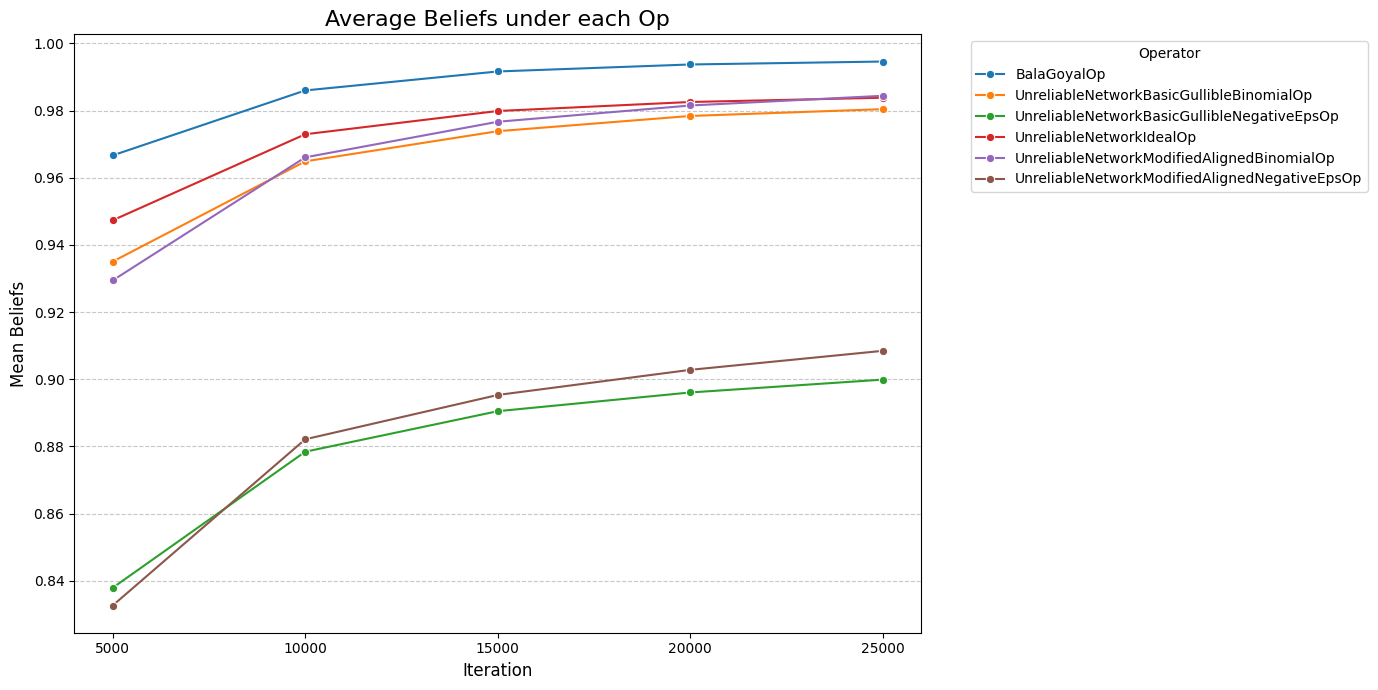

In [11]:
# Ensure 'iteration' is in columns
if 'iteration' not in blfs.columns:
    if isinstance(blfs.index, pd.MultiIndex):
        # Extract 'iteration' from MultiIndex if available
        blfs = blfs.reset_index()
    else:
        # Create a synthetic 'iteration' based on row indices
        blfs['iteration'] = blfs.index

# Specify snapshot iterations
snapshot_iterations = [5000, 10000, 15000, 20000, 25000]

# Filter beliefs for the specific snapshot iterations
filtered_beliefs = blfs[blfs['iteration'].isin(snapshot_iterations)]

# Aggregate beliefs at graph level for these iterations
snapshot_aggregated = (
    filtered_beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

# Visualize average beliefs at each snapshot iteration
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=snapshot_aggregated,
    x="iteration",
    y="mean_beliefs",
    hue="op",
    marker="o",
    palette="tab10"
)
plt.title("Average Beliefs under each Op", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Beliefs", fontsize=12)
plt.xticks(snapshot_iterations)  # Ensure iterations align
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig("images/average_beliefs_snapshots.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/average_beliefs_snapshots.svg", format="svg", bbox_inches="tight")

plt.show()
